In [156]:
import matplotlib
import numpy as np
import pandas as pd
import pickle
import gzip

import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec

import bisect
from scipy import interpolate

from scipy import stats
import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
with gzip.open('data/energy_density_daynite.gzip','rb') as file:
    d = pickle.load(file)
    
gridlats = d['gridlats']
gridlons = d['gridlons']
gridLs = d['gridLs']
pwr_maps_total = d['pwr_map_total']
pwr_maps_linear = d['pwr_map_linear']
cmt = d['cur_map']

<IPython.core.display.Javascript object>


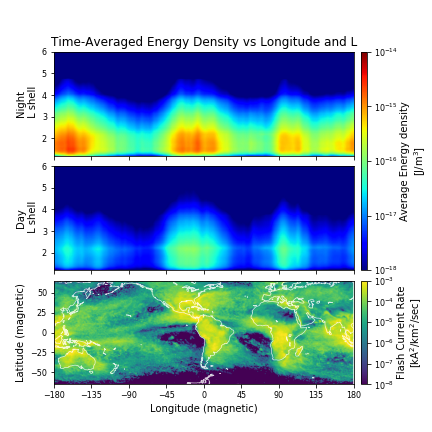

-100.0 -2.22205328881


In [3]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [-18, -14]


fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])
p0 = ax[0].pcolormesh(gridlons, gridLs, pwr_maps_total[0].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1], shading='gouraud')
p1 = ax[1].pcolormesh(gridlons, gridLs, pwr_maps_total[12].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1], shading='gouraud')
ax[0].set_ylim([1.2, 6])
ax[1].set_ylim([1.2, 6])

# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Average Energy density\n[J/m$^3$]') 




clims2 = [-8, -3]
print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolormesh(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'), shading='gouraud')
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8, linewidth=0.7)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-65, 65])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 

xtix = np.arange(-180, 181, 45) 
ax[0].set_xticks(xtix)
ax[1].set_xticks(xtix)
ax[2].set_xticks(xtix)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Night\n L shell')
ax[1].set_ylabel('Day\n L shell')
ax[1].set_xticklabels([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')
# ax[2].set_aspect('equal')
ax[0].set_title('Time-Averaged Energy Density vs Longitude and L')
# gs.tight_layout(fig)

fig.subplots_adjust(right=0.85)

fig.savefig('Energy_density_daynite.png',dpi=300)

720 1441


<IPython.core.display.Javascript object>


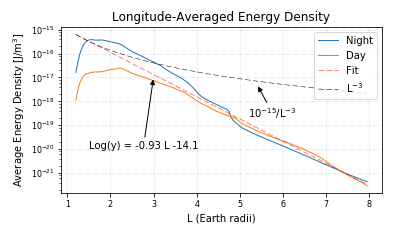

In [95]:
import scipy.optimize

# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


dens_vs_L = dict()

# lonlims = [-50, 10]  # ~ approximately over the US
lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print left_ind, right_ind

for k in pwr_maps_linear.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind, :], axis=0)/(right_ind - left_ind)
    

def func(x, a, b):
    return a + b*x
popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10((dens_vs_L[0] + dens_vs_L[12])/2.))

# print popt

fit = func(gridLs, popt[0], popt[1])
fig, ax = plt.subplots(1,1)
ax.semilogy(gridLs, dens_vs_L[0], linewidth=1, label='Night')
ax.semilogy(gridLs, dens_vs_L[12], linewidth=1, label='Day')
ax.semilogy(gridLs, pow(10,fit), '--',linewidth=1, label='Fit', alpha=0.5, color='r')
# ax.set_ylim([-18, -14])
ax.grid('on', which='major', linestyle='--', alpha=0.3)


Lcube_trend = (1.1e-15)*pow(gridLs, -3)
ax.plot(gridLs, Lcube_trend, 'k--', linewidth=0.5, label='L$^{-3}$')

ax.annotate(xy=(5.4, 5e-18),xytext=(5.2,2e-19),s="10$^{-15}$/L$^{-3}$",arrowprops={'arrowstyle':'-|>','facecolor':'k'})
ax.annotate(xy=(3, 1e-17), xytext=(1.5, 1e-20), s="Log(y) = %2.2f L %2.1f"%(popt[1], popt[0]), arrowprops={'arrowstyle':'-|>','facecolor':'k'})

ax.legend(loc='upper right')


ax.set_xlabel('L (Earth radii)')
ax.set_ylabel('Average Energy Density [J/m$^3$]')
# ax.set_title('Time-Averaged Energy Density\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))
ax.set_title('Longitude-Averaged Energy Density')


fig.tight_layout()
# fig.savefig('density_vs_L.png',dpi=300)
fig.savefig('density_vs_L_with_fit.pdf')

In [96]:
with gzip.open('data/energy_density_daynite_multiple_kp.gzip','rb') as file:
    d = pickle.load(file)
    
gridlats = d['gridlats']
gridlons = d['gridlons']
gridLs = d['gridLs']
pwr_maps = d['pwr_map_total']
pwr_maps_linear = d['pwr_map_linear']
cmt = d['cur_map']

720 1441


<IPython.core.display.Javascript object>


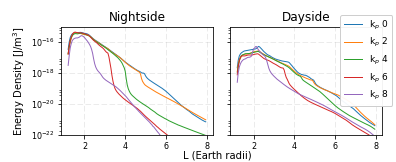

In [107]:
import scipy.optimize

# Line plot of day + night trends over the US:
# This version broken out for different Kp:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 1.25
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 9,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



dens_vs_L = dict()

# lonlims = [-50, 10]  # ~ approximately over the US
lonlims = [-180, 180]
left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print left_ind, right_ind

for k in pwr_maps_linear.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind, :], axis=0)/(right_ind - left_ind)


fig, ax = plt.subplots(1,2, sharex=True, sharey=True)


# for k in dens_vs_L.keys():

cm = plt.get_cmap('Vega10')
for ind, kp in enumerate([3, 20, 40, 60, 80]):
    color = cm(ind)
    ax[0].semilogy(gridLs, dens_vs_L[(0,  kp)], linewidth=1, label = 'K$_p$ %d'%int(np.floor(kp/10)), color=color)
    ax[1].semilogy(gridLs, dens_vs_L[(12, kp)], linewidth=1, label = 'k$_p$ %d'%int(np.floor(kp/10)), color=color)


# ax.set_ylim([-18, -14])
ax[0].grid('on', which='major', linestyle='--', alpha=0.3)
ax[1].grid('on', which='major', linestyle='--', alpha=0.3)




# ax[1].legend()
ax[0].set_ylim([1e-22, 1e-15])
# ax[1].set_xlabel('L (Earth radii)')
ax[0].set_ylabel('Energy Density [J/m$^3$]')
ax[0].set_title('Nightside')
ax[1].set_title('Dayside')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.1,1.15), framealpha=0.95)

# ax[1].set_ylabel('Daytime \n Energy Density [J/m$^3$]')
# fig.suptitle('Time-Averaged Energy Density\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))


# ax.set_xlabel('L (Earth radii)')
# ax.set_ylabel('Average Energy Density [J/m$^3$]')
# # ax.set_title('Time-Averaged Energy Density\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))
# ax.set_title('Longitude-Averaged Energy Density')
fig.tight_layout()
fig.text(0.55, 0.02, 'L (Earth radii)', ha='center')
# fig.savefig('density_vs_L.png',dpi=300)
fig.savefig('density_vs_L_multiple_kp.pdf')

## Now, with frequency axis!

In [157]:
with gzip.open('data/energy_density_daynite_with_spectrum_logscale.gzip','rb') as file:
    d = pickle.load(file)
    
gridlats = d['gridlats']
gridlons = d['gridlons']
gridLs = d['gridLs']
gridFs = d['gridFs']
pwr_maps = d['pwr_maps']
pwr_maps_linear = d['pwr_maps_linear']
cmt = d['cur_map']

(360, 100, 136)


<IPython.core.display.Javascript object>


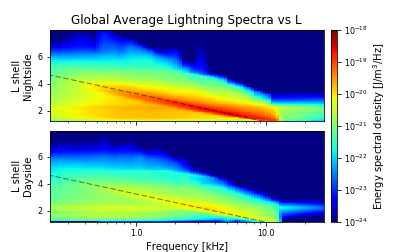

In [176]:
# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
# Plot spectral density vs L-shell over the US:
dens_vs_L = dict()

lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print np.shape(pwr_maps_linear[0])
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    dens_vs_L[k] = np.log10(dens_vs_L[k])
    dens_vs_L[k][np.isinf(dens_vs_L[k])] = -100

    
clims = [-24, -18]
cm = plt.cm.jet    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


cax = plt.subplot(gs[0:2,1])

for ind, k in enumerate(dens_vs_L.keys()):
    p = ax[ind].pcolormesh(gridFs/1000., gridLs, dens_vs_L[k].T, vmin = clims[0], vmax=clims[1], cmap = cm, shading='gourad')
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')


    

# Plot the peak fit trendline:

peakfit = pow(10, 4.56 - 0.48*gridLs)
ax[0].plot(peakfit*1e-3, gridLs, 'k--',linewidth=1,alpha=0.5)
ax[1].plot(peakfit*1e-3, gridLs, 'k--',linewidth=1,alpha=0.5)
    

ax[0].set_xticklabels([])
ax[0].set_ylabel('L shell\nNightside')
ax[-1].set_ylabel('L shell\nDayside')
ax[-1].set_xlabel('Frequency [kHz]')
ax[0].set_xlim([gridFs[0]/1000, gridFs[-1]/1000])
ax[1].set_xlim([gridFs[0]/1000, gridFs[-1]/1000])
# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy spectral density [J/m$^3$/Hz]') 

ax[0].set_title('Global Average Lightning Spectra vs L')

fig.subplots_adjust(right=0.85, bottom=0.12)
fig.savefig('lightning_spectra_vs_L_logscale.png', dpi=300)

<IPython.core.display.Javascript object>


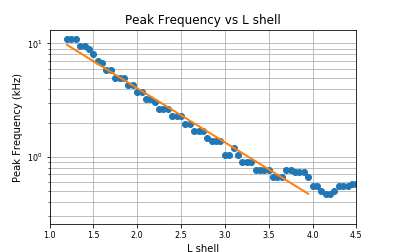

(100, 136)
[ 4.56084165 -0.4777901 ]


In [160]:
import scipy.optimize

# Find peaks in spectra and do a fit:

def func(x, a, b):
    return a + b*x
# popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10(maxF[k]))

# print popt

# fit = func(gridLs, popt[0], popt[1])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

# p , e = optimize.curve_fit(piecewise_linear, gridLs, gridFs[k])
# xd = np.linspace(0, 15, 100)
# pl.plot(x, y, "o")
# pl.plot(xd, piecewise_linear(xd, *p))

fig, ax = plt.subplots(1,1)

dens_vs_L_lin = dict()
for k in pwr_maps.keys()[0:1]:
    dens_vs_L_lin[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)


maxF = dict()
for k in dens_vs_L_lin.keys()[0:2]:

    print np.shape(dens_vs_L_lin[k])
    maxF[k] = gridFs[np.argmax(dens_vs_L_lin[k], axis=0)]
    p, e = scipy.optimize.curve_fit(func, gridLs[gridLs < 4], np.log10(maxF[k][gridLs < 4]))
#     p , e = scipy.optimize.curve_fit(piecewise_linear, gridLs, np.log10(gridFs[k]))
    print p
    ax.semilogy(gridLs, (maxF[k])/1000., 'o')    
    fit = func(gridLs[gridLs < 4], *p)
    ax.semilogy(gridLs[gridLs < 4], pow(10,fit)/1000., linewidth=2)
    ax.grid('on', which='both')
    ax.set_xlim([1,4.5])
    ax.set_xlabel("L shell")
    ax.set_ylabel('Peak Frequency (kHz)')
    ax.set_title('Peak Frequency vs L shell')



In [166]:
pow(10, 4.56 - 0.48*gridLs)

array([  9.63829024e+03,   9.12010839e+03,   8.62978548e+03,
         8.16582371e+03,   7.72680585e+03,   7.31139083e+03,
         6.91830971e+03,   6.54636174e+03,   6.19441075e+03,
         5.86138165e+03,   5.54625713e+03,   5.24807460e+03,
         4.96592321e+03,   4.69894109e+03,   4.44631267e+03,
         4.20726628e+03,   3.98107171e+03,   3.76703799e+03,
         3.56451133e+03,   3.37287309e+03,   3.19153786e+03,
         3.01995172e+03,   2.85759054e+03,   2.70395836e+03,
         2.55858589e+03,   2.42102905e+03,   2.29086765e+03,
         2.16770410e+03,   2.05116218e+03,   1.94088588e+03,
         1.83653834e+03,   1.73780083e+03,   1.64437172e+03,
         1.55596563e+03,   1.47231250e+03,   1.39315680e+03,
         1.31825674e+03,   1.24738351e+03,   1.18032064e+03,
         1.11686325e+03,   1.05681751e+03,   1.00000000e+03,
         9.46237161e+02,   8.95364766e+02,   8.47227414e+02,
         8.01678063e+02,   7.58577575e+02,   7.17794291e+02,
         6.79203633e+02,